## Offensive Language Identification - CNN


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install unidecode

     |████████████████████████████████| 245kB 5.7MB/s 


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.models import *
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.initializers import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import *
import tensorflow as tf
import os
import time
import gc
import re
from unidecode import unidecode

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Get reproducable results

In [ ]:
from numpy.random import seed
#from tensorflow import set_random_seed

seed(726)
#set_random_seed(726)

### Loading the training and testing files

In [ ]:
train = pd.read_csv("./drive/MyDrive/nlp595/Data/training/offenseval-training-v1.tsv", sep='\t')

test_tweets = pd.read_csv("./drive/MyDrive/nlp595/Data/testing/testset-taska.tsv", sep='\t')
test_labels = pd.read_csv("./drive/MyDrive/nlp595/Data/testing/labels-test-a.csv", names = ["id", "subtask_a"])

test = pd.merge(test_tweets, test_labels, on=['id','id'])
print("Train shape : ", train.shape)
print("Test shape : ", test.shape)

Train shape :  (13240, 5)
Test shape :  (860, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


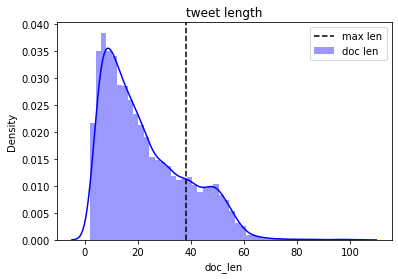

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

train['doc_len'] = train["tweet"].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train['doc_len'].mean() + train['doc_len'].std()).astype(int)
sns.distplot(train['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('tweet length'); plt.legend()
plt.show()

Changing case of the tweets to lower case, since the embedding model only has lower case words

In [ ]:
train["tweet"] = train["tweet"].str.lower()
test["tweet"] = test["tweet"].str.lower()

cleaning the puncutation marks

In [ ]:
def is_emoji(s):
    return s in UNICODE_EMOJI

def sepa_emoji(text):
    res = ''
    for c in text:
      if is_emoji(c):
        res += ' ' 
      res += c
    return res.strip()

train_data["tweet"] = train_data["tweet"].apply(lambda x: sepa_emoji(x))
test_data["tweet"] = test_data["tweet"].apply(lambda x: sepa_emoji(x))

In [ ]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = None # how many unique words to use (i.e num rows in embedding vector)
maxlen = max_seq_len # max number of words in a question to use #99.99%

## fill up the missing values
X = train["tweet"].fillna("_na_").values
X_test = test["tweet"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features, filters='')
tokenizer.fit_on_texts(list(X))

X = tokenizer.texts_to_sequences(X)
X_test = tokenizer.texts_to_sequences(X_test)

## Pad the sentences 
X = pad_sequences(X, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

## Get the target values
Y = train['subtask_a'].values
Y

array(['OFF', 'OFF', 'NOT', ..., 'OFF', 'OFF', 'NOT'], dtype=object)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

le.fit(Y)
encoded_Y = le.transform(Y)
encoded_Y

array([1, 1, 0, ..., 1, 1, 0])

Building the Embedding matrix

In [ ]:
word_index = tokenizer.word_index
max_features = len(word_index)+1
def load_glove(word_index):
    word_embedding_file = './drive/MyDrive/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(word_embedding_file) if o.split(" ")[0] in word_index)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 


Only Glove vectors have been used in embedding matrix. Can explore it further in future

In [ ]:
embedding_matrix = load_glove(word_index)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
filter_sizes = [1,2,3,5]
num_filters = 32

def get_model():    
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.4)(x)
    x = Reshape((maxlen, embed_size, 1))(x)
    
    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embed_size), kernel_initializer='normal',
                                                                                    activation='relu')(x)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embed_size), kernel_initializer='normal',
                                                                                    activation='relu')(x)
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embed_size), kernel_initializer='normal',
                                                                                    activation='relu')(x)
    conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[3], embed_size), kernel_initializer='normal',
                                                                                    activation='relu')(x)
    
    maxpool_0 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1))(conv_0)
    maxpool_1 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1))(conv_1)
    maxpool_2 = MaxPool2D(pool_size=(maxlen - filter_sizes[2] + 1, 1))(conv_2)
    maxpool_3 = MaxPool2D(pool_size=(maxlen - filter_sizes[3] + 1, 1))(conv_3)
        
    z = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2, maxpool_3])   
    z = Flatten()(z)
    z = Dropout(0.1)(z)
        
    outp = Dense(1, activation="sigmoid")(z)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


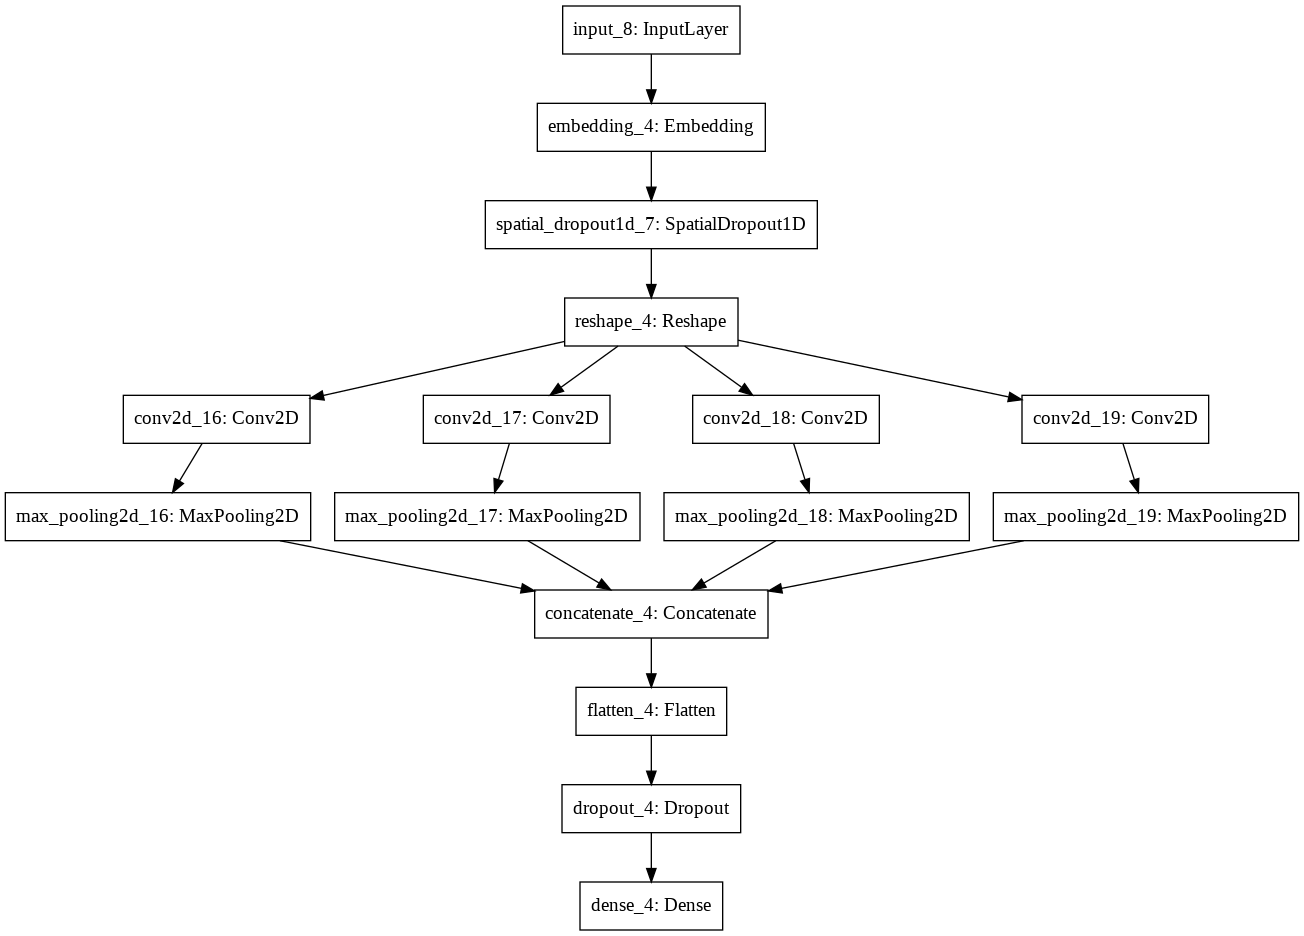

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file = 'cnn_model.png')

In [ ]:
def f1_smart(y_true, y_pred):
    args = np.argsort(y_pred)
    tp = y_true.sum()
    fs = (tp - np.cumsum(y_true[args[:-1]])) / np.arange(y_true.shape[0] + tp - 1, tp, -1)
    res_idx = np.argmax(fs)
    return 2 * fs[res_idx], (y_pred[args[res_idx]] + y_pred[args[res_idx + 1]]) / 2

Training with early stopping and reducing learning rate on plateu. In each fold values for the test set is also predicted, And after the process, predicted values for the test file would be mean from each fold

In [ ]:
from matplotlib import pyplot as plt


Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 38, 300)      6036600     input_19[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_18 (SpatialDr (None, 38, 300)      0           embedding_15[0][0]               
__________________________________________________________________________________________________
reshape_15 (Reshape)            (None, 38, 300, 1)   0           spatial_dropout1d_18[0][0]       
___________________________________________________________________________________________

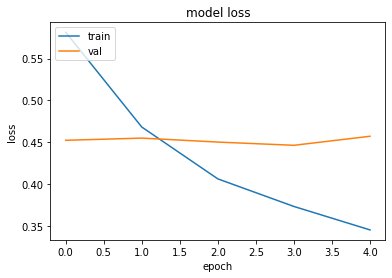

42/42 - 1s
14/14 - 0s
Optimal F1: 0.6981 at threshold: 0.3214
Epoch 1/5
166/166 - 27s - loss: 0.5534 - accuracy: 0.7263 - val_loss: 0.4707 - val_accuracy: 0.7908

Epoch 00001: val_loss improved from inf to 0.47071, saving model to ./drive/MyDrive/cnn_weights_best.h5
Epoch 2/5
166/166 - 27s - loss: 0.4605 - accuracy: 0.7870 - val_loss: 0.4536 - val_accuracy: 0.7927

Epoch 00002: val_loss improved from 0.47071 to 0.45363, saving model to ./drive/MyDrive/cnn_weights_best.h5
Epoch 3/5
166/166 - 26s - loss: 0.4067 - accuracy: 0.8207 - val_loss: 0.4717 - val_accuracy: 0.7817

Epoch 00003: val_loss did not improve from 0.45363

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
Epoch 4/5
166/166 - 26s - loss: 0.3565 - accuracy: 0.8440 - val_loss: 0.4625 - val_accuracy: 0.7900

Epoch 00004: val_loss did not improve from 0.45363

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.
Epoch 5/5
166/166 - 26s - loss: 0.3192 - accuracy: 0.8622 

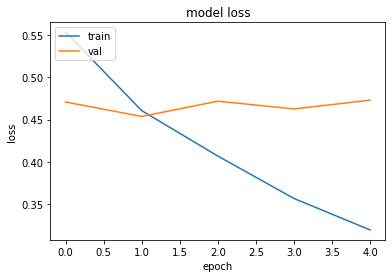

42/42 - 1s
14/14 - 0s
Optimal F1: 0.6911 at threshold: 0.3464
Epoch 1/5
166/166 - 27s - loss: 0.5752 - accuracy: 0.7114 - val_loss: 0.4609 - val_accuracy: 0.7851

Epoch 00001: val_loss improved from inf to 0.46089, saving model to ./drive/MyDrive/cnn_weights_best.h5
Epoch 2/5
166/166 - 26s - loss: 0.4643 - accuracy: 0.7851 - val_loss: 0.4544 - val_accuracy: 0.7904

Epoch 00002: val_loss improved from 0.46089 to 0.45441, saving model to ./drive/MyDrive/cnn_weights_best.h5
Epoch 3/5
166/166 - 26s - loss: 0.4085 - accuracy: 0.8156 - val_loss: 0.4612 - val_accuracy: 0.7878

Epoch 00003: val_loss did not improve from 0.45441

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
Epoch 4/5
166/166 - 26s - loss: 0.3577 - accuracy: 0.8387 - val_loss: 0.4588 - val_accuracy: 0.7881

Epoch 00004: val_loss did not improve from 0.45441

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.
Epoch 5/5
166/166 - 26s - loss: 0.3228 - accuracy: 0.8624 

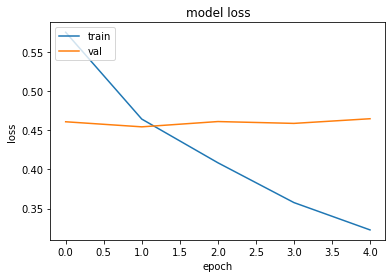

42/42 - 1s
14/14 - 0s
Optimal F1: 0.6863 at threshold: 0.2985
Epoch 1/5
166/166 - 27s - loss: 0.5642 - accuracy: 0.7125 - val_loss: 0.4761 - val_accuracy: 0.7829

Epoch 00001: val_loss improved from inf to 0.47605, saving model to ./drive/MyDrive/cnn_weights_best.h5
Epoch 2/5
166/166 - 26s - loss: 0.4573 - accuracy: 0.7884 - val_loss: 0.4534 - val_accuracy: 0.7893

Epoch 00002: val_loss improved from 0.47605 to 0.45338, saving model to ./drive/MyDrive/cnn_weights_best.h5
Epoch 3/5
166/166 - 26s - loss: 0.4082 - accuracy: 0.8171 - val_loss: 0.4684 - val_accuracy: 0.7810

Epoch 00003: val_loss did not improve from 0.45338

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
Epoch 4/5
166/166 - 26s - loss: 0.3581 - accuracy: 0.8441 - val_loss: 0.4789 - val_accuracy: 0.7745

Epoch 00004: val_loss did not improve from 0.45338

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.
Epoch 5/5
166/166 - 26s - loss: 0.3241 - accuracy: 0.8620 

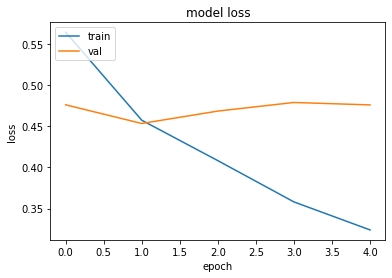

42/42 - 1s
14/14 - 0s
Optimal F1: 0.6830 at threshold: 0.3333
Epoch 1/5
166/166 - 27s - loss: 0.5759 - accuracy: 0.7099 - val_loss: 0.5041 - val_accuracy: 0.7719

Epoch 00001: val_loss improved from inf to 0.50409, saving model to ./drive/MyDrive/cnn_weights_best.h5
Epoch 2/5
166/166 - 26s - loss: 0.4621 - accuracy: 0.7863 - val_loss: 0.4611 - val_accuracy: 0.7874

Epoch 00002: val_loss improved from 0.50409 to 0.46105, saving model to ./drive/MyDrive/cnn_weights_best.h5
Epoch 3/5
166/166 - 26s - loss: 0.4044 - accuracy: 0.8173 - val_loss: 0.4954 - val_accuracy: 0.7817

Epoch 00003: val_loss did not improve from 0.46105

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
Epoch 4/5
166/166 - 26s - loss: 0.3521 - accuracy: 0.8451 - val_loss: 0.4744 - val_accuracy: 0.7813

Epoch 00004: val_loss did not improve from 0.46105

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.
Epoch 5/5
166/166 - 26s - loss: 0.3216 - accuracy: 0.8627 

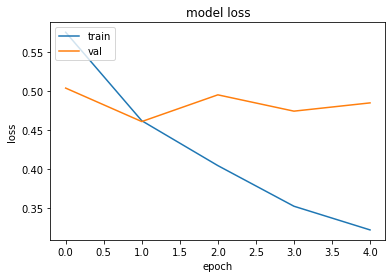

42/42 - 1s
14/14 - 0s
Optimal F1: 0.6891 at threshold: 0.3333


<Figure size 432x288 with 0 Axes>

In [ ]:
kfold = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
bestscore = []
y_test = np.zeros((X_test.shape[0], ))
for i, (train_index, valid_index) in enumerate(kfold.split(X, encoded_Y)):
    X_train, X_val, Y_train, Y_val = X[train_index], X[valid_index], encoded_Y[train_index], encoded_Y[valid_index]
    filepath="./drive/MyDrive/cnn_weights_best.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=1, min_lr=0.00001, verbose=2)
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose=2, mode='auto')
    callbacks = [checkpoint, reduce_lr]
    model = get_model()
    if i == 0:print(model.summary()) 
    history = model.fit(X_train, Y_train, batch_size=64, epochs=5, validation_data=(X_val, Y_val), verbose=2, callbacks=callbacks, 
             )
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    plt.savefig('image' + str(i) + '.png')

    model.load_weights(filepath)
    y_pred = model.predict([X_val], batch_size=64, verbose=2)
    y_test += np.squeeze(model.predict([X_test], batch_size=64, verbose=2))/5
    f1, threshold = f1_smart(np.squeeze(Y_val), np.squeeze(y_pred))
    print('Optimal F1: {:.4f} at threshold: {:.4f}'.format(f1, threshold))
    bestscore.append(threshold)

Converting the predictions for integer.

In [ ]:
y_test = y_test.reshape((-1, 1))
pred_test_y = (y_test>np.mean(bestscore)).astype(int)
test['predictions'] = le.inverse_transform(pred_test_y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(test["subtask_a"], test['predictions']).ravel()
cm = confusion_matrix(test["subtask_a"], test['predictions'])
(tn, fp, fn, tp)

(537, 83, 68, 172)

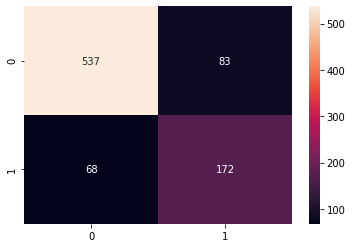

In [ ]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='g')


### Accuracy

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test["subtask_a"], test['predictions'])

0.8244186046511628

In [ ]:
from sklearn.metrics import f1_score
f1_score(test["subtask_a"], test['predictions'], labels=None, pos_label=1, average='macro', sample_weight=None)

0.7858420944135229

Inspired from: https://github.com/TharinduDR/Aggression-Identification
